# Exploratory Data Analysis

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os

In [2]:
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
%config InlineBackend.figure_format = 'retina'

In [3]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

In [4]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [5]:
from pycaret.regression import *

In [6]:
def plot_distribution(dataset):
    
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(20,30))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    
    rows = math.ceil(float(dataset.shape[1]) / 3)
    
    for i, column in enumerate(dataset.columns):
        
        ax = fig.add_subplot(rows, 3, i + 1)
        ax.set_title(column)
        
        if dataset.dtypes[column] == np.object:
            
            if(len(dataset[column].unique()) > 10):
               
                most_frequent = dataset[column].value_counts().sort_values(ascending=False)[:10].index.tolist()
                g = sns.countplot(y=column, data=dataset[dataset[column].isin(most_frequent)])
                ax.set_title(column + " (10 out of " + str(len(dataset[column].unique())) + " most frequent values)")
            else:
                g = sns.countplot(y=column, data=dataset)
            
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

### Loading the test data into the data frame.

In [7]:
tdf = pd.read_csv("input/test_set_asina.txt", sep="\t", encoding="unicode_escape", 
                  usecols=['NP_type', 'Coating','core_size_nm','hydro_size_nm','Surf_charge_mV','Surface_area_m2_g',
                           'shape','Dose_microg_mL','Duration_h','Cell_name','Cell_species','cell_Organ','Cell_morphology',
                           'Cell_age','cell_type','sex','Assay','Test_indicator','Viability'])

In [8]:
tdf.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability
0,Ag,None,150,"144,04",?,?,Sphere,1,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,"80,14641982"
1,Ag,None,150,"145,0888889",?,?,Sphere,5,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,"65,04863941"
2,Ag,None,150,"146,4",?,?,Sphere,10,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,"64,26526565"
3,Ag,None,150,"149,0222222",?,?,Sphere,20,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,"57,00693716"
4,Ag,None,150,"154,2666667",?,?,Sphere,40,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,"35,84440769"


### Replace '?' with null values and keep rows where Viability is not null

In [9]:
tdf = tdf.replace('?', np.nan)
tdf = tdf[tdf['Viability'].notna()]

In [10]:
tdf.dtypes

NP_type               object
Coating               object
core_size_nm           int64
hydro_size_nm         object
Surf_charge_mV        object
Surface_area_m2_g    float64
shape                 object
Dose_microg_mL        object
Duration_h             int64
Cell_name             object
Cell_species          object
cell_Organ            object
Cell_morphology       object
Cell_age              object
cell_type             object
sex                   object
Assay                 object
Test_indicator        object
Viability             object
dtype: object

### Replace floating-point comma with dot and make sure numerical columns have numeric data type

In [11]:
tdf["core_size_nm"] = pd.to_numeric(tdf["core_size_nm"])

tdf["hydro_size_nm"] = tdf["hydro_size_nm"].str.replace(',','.')
tdf["hydro_size_nm"] = pd.to_numeric(tdf["hydro_size_nm"])

tdf["Surf_charge_mV"] = tdf["Surf_charge_mV"].str.replace(',','.')
tdf["Surf_charge_mV"] = pd.to_numeric(tdf["Surf_charge_mV"])

tdf["Dose_microg_mL"] = tdf["Dose_microg_mL"].str.replace(',','.')
tdf["Dose_microg_mL"] = pd.to_numeric(tdf["Dose_microg_mL"])

tdf["Viability"] = tdf["Viability"].str.replace(',','.')
tdf["Viability"] = pd.to_numeric(tdf["Viability"])

print("Duration_h: " + str(pd.api.types.is_numeric_dtype(tdf['Duration_h'])))
print("core_size_nm: " + str(pd.api.types.is_numeric_dtype(tdf['core_size_nm'])))
print("hydro_size_nm: " + str(pd.api.types.is_numeric_dtype(tdf['hydro_size_nm'])))
print("Surf_charge_mV: " + str(pd.api.types.is_numeric_dtype(tdf['Surf_charge_mV'])))
print("Surface_area_m2_g: " + str(pd.api.types.is_numeric_dtype(tdf['Surface_area_m2_g'])))
print("Dose_microg_mL: " + str(pd.api.types.is_numeric_dtype(tdf['Dose_microg_mL'])))
print("Viability: " + str(pd.api.types.is_numeric_dtype(tdf['Viability'])))

Duration_h: True
core_size_nm: True
hydro_size_nm: True
Surf_charge_mV: True
Surface_area_m2_g: True
Dose_microg_mL: True
Viability: True


In [12]:
tdf['Assay'] = tdf['Assay'].str.strip()

In [13]:
data_test_df = tdf.drop_duplicates()

In [14]:
data_test_df.shape

(969, 19)

In [15]:
data_test_df.dtypes

NP_type               object
Coating               object
core_size_nm           int64
hydro_size_nm        float64
Surf_charge_mV       float64
Surface_area_m2_g    float64
shape                 object
Dose_microg_mL       float64
Duration_h             int64
Cell_name             object
Cell_species          object
cell_Organ            object
Cell_morphology       object
Cell_age              object
cell_type             object
sex                   object
Assay                 object
Test_indicator        object
Viability            float64
dtype: object

In [16]:
data_test_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability
0,Ag,None,150,144.040000,NaN,NaN,Sphere,1.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,80.146420
1,Ag,None,150,145.088889,NaN,NaN,Sphere,5.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,65.048639
2,Ag,None,150,146.400000,NaN,NaN,Sphere,10.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,64.265266
3,Ag,None,150,149.022222,NaN,NaN,Sphere,20.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,57.006937
4,Ag,None,150,154.266667,NaN,NaN,Sphere,40.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,35.844408


In [17]:
data_test_df['NP_type'].unique()

array(['Ag', 'TiO2'], dtype=object)

In [18]:
data_test_df['shape'].unique()

array(['Sphere', nan], dtype=object)

In [19]:
data_test_df['Assay'].unique()

array(['MTT', 'Alamar_Blue', 'WST-1'], dtype=object)

In [20]:
data_test_df.loc[data_test_df["NP_type"] == 'TiO2', "nanomaterial_group"] = "meta_oxide" 
data_test_df.loc[data_test_df["NP_type"] == 'Ag', "nanomaterial_group"] = "other"

In [21]:
data_test_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability,nanomaterial_group
0,Ag,None,150,144.040000,NaN,NaN,Sphere,1.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,80.146420,other
1,Ag,None,150,145.088889,NaN,NaN,Sphere,5.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,65.048639,other
2,Ag,None,150,146.400000,NaN,NaN,Sphere,10.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,64.265266,other
3,Ag,None,150,149.022222,NaN,NaN,Sphere,20.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,57.006937,other
4,Ag,None,150,154.266667,NaN,NaN,Sphere,40.0,24,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,35.844408,other


### Loading the training data into the data frame.

In [22]:
# utf-8 encoding:
# df = pd.read_csv("input/nano_dataset.txt", sep="\t", encoding="utf-8")

df = pd.read_csv("input/nano_dataset.txt", sep="\t", encoding="unicode_escape")

### Replace '?' with null values and keep rows where Viability is not null

In [23]:
df = df.replace('?', np.nan)
df = df[df['Viability'].notna()]

### Replace floating-point comma with dot and make sure numerical columns have numeric data type

In [24]:
df["core_size_nm"] = df["core_size_nm"].str.replace(',','.')
df["core_size_nm"] = pd.to_numeric(df["core_size_nm"])

df["hydro_size_nm"] = df["hydro_size_nm"].str.replace(',','.')
df["hydro_size_nm"] = pd.to_numeric(df["hydro_size_nm"])

df["Surf_charge_mV"] = df["Surf_charge_mV"].str.replace(',','.')
df["Surf_charge_mV"] = pd.to_numeric(df["Surf_charge_mV"])

df["Surface_area_m2_g"] = df["Surface_area_m2_g"].str.replace(',','.')
df["Surface_area_m2_g"] = pd.to_numeric(df["Surface_area_m2_g"])

df["Dose_microg_mL"] = df["Dose_microg_mL"].str.replace(',','.')
df["Dose_microg_mL"] = pd.to_numeric(df["Dose_microg_mL"])

df["Viability"] = df["Viability"].str.replace(',','.')
df["Viability"] = pd.to_numeric(df["Viability"])

print("Duration_h: " + str(pd.api.types.is_numeric_dtype(df['Duration_h'])))
print("core_size_nm: " + str(pd.api.types.is_numeric_dtype(df['core_size_nm'])))
print("hydro_size_nm: " + str(pd.api.types.is_numeric_dtype(df['hydro_size_nm'])))
print("Surf_charge_mV: " + str(pd.api.types.is_numeric_dtype(df['Surf_charge_mV'])))
print("Surface_area_m2_g: " + str(pd.api.types.is_numeric_dtype(df['Surface_area_m2_g'])))
print("Dose_microg_mL: " + str(pd.api.types.is_numeric_dtype(df['Dose_microg_mL'])))
print("Viability: " + str(pd.api.types.is_numeric_dtype(df['Viability'])))

Duration_h: True
core_size_nm: True
hydro_size_nm: True
Surf_charge_mV: True
Surface_area_m2_g: True
Dose_microg_mL: True
Viability: True


### Cheack the dataframe

In [25]:
df.shape

(11591, 19)

In [26]:
df.head(n=5)

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability
0,Au,None,39.0,NaN,NaN,NaN,Rod,0.3,24.0,143B,Human,Bone,Mixed,Adult,cancer,female,MTT,TetrazoliumSalt,84.99
1,Au,None,39.0,NaN,NaN,NaN,Rod,0.6,24.0,143B,Human,Bone,Mixed,Adult,cancer,female,MTT,TetrazoliumSalt,86.85
2,Au,None,39.0,NaN,NaN,NaN,Rod,1.2,24.0,143B,Human,Bone,Mixed,Adult,cancer,female,MTT,TetrazoliumSalt,85.48
3,Au,None,39.0,NaN,NaN,NaN,Rod,2.5,24.0,143B,Human,Bone,Mixed,Adult,cancer,female,MTT,TetrazoliumSalt,70.72
4,Au,None,39.0,NaN,NaN,NaN,Rod,5.0,24.0,143B,Human,Bone,Mixed,Adult,cancer,female,MTT,TetrazoliumSalt,54.09


### Check data types

In [27]:
df.dtypes

NP_type               object
Coating               object
core_size_nm         float64
hydro_size_nm        float64
Surf_charge_mV       float64
Surface_area_m2_g    float64
shape                 object
Dose_microg_mL       float64
Duration_h           float64
Cell_name             object
Cell_species          object
cell_Organ            object
Cell_morphology       object
Cell_age              object
cell_type             object
sex                   object
Assay                 object
Test_indicator        object
Viability            float64
dtype: object

### Describe dataframe

#### Describe numerical columns

In [28]:
df.describe()

,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,Dose_microg_mL,Duration_h,Viability
count,10784.000000,2834.000000,5377.000000,850.000000,11369.000000,11255.000000,11591.000000
mean,55.983907,321.677421,-6.299405,100.796365,88.920945,34.044958,72.769054
std,93.620772,307.192574,28.965272,103.692893,527.034851,34.059479,32.557049
min,0.840000,8.700000,-158.000000,7.000000,0.000000,0.000000,-58.900000
25%,6.000000,120.000000,-26.960000,22.000000,0.010000,24.000000,51.290000
50%,21.000000,239.000000,-11.000000,57.000000,1.311929,24.000000,83.240000
75%,60.000000,404.000000,12.100000,177.570000,50.000000,48.000000,96.970000
max,900.000000,2029.000000,256.000000,576.230000,15000.000000,672.000000,404.810000


#### Describe categorical columns

In [29]:
df.describe(include=["bool", "object"])

,NP_type,Coating,shape,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator
count,11591,11591,4532,11591,11591,11591,11571,10818,11489,8508,11591,11342
unique,79,151,13,285,22,65,37,5,2,2,35,17
top,CdSe,None,Sphere,A549,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt
freq,1727,7881,3300,949,9003,2008,5821,7925,7066,5053,5066,7590


### Count missing values

In [30]:
print(df.isnull().sum())

NP_type                  0
Coating                  0
core_size_nm           807
hydro_size_nm         8757
Surf_charge_mV        6214
Surface_area_m2_g    10741
shape                 7059
Dose_microg_mL         222
Duration_h             336
Cell_name                0
Cell_species             0
cell_Organ               0
Cell_morphology         20
Cell_age               773
cell_type              102
sex                   3083
Assay                    0
Test_indicator         249
Viability                0
dtype: int64


### Remove duplicate rows

In [31]:
data_df = df.drop_duplicates()

In [32]:
data_df.shape

(11423, 19)

### Plot features (categorical and numerical)

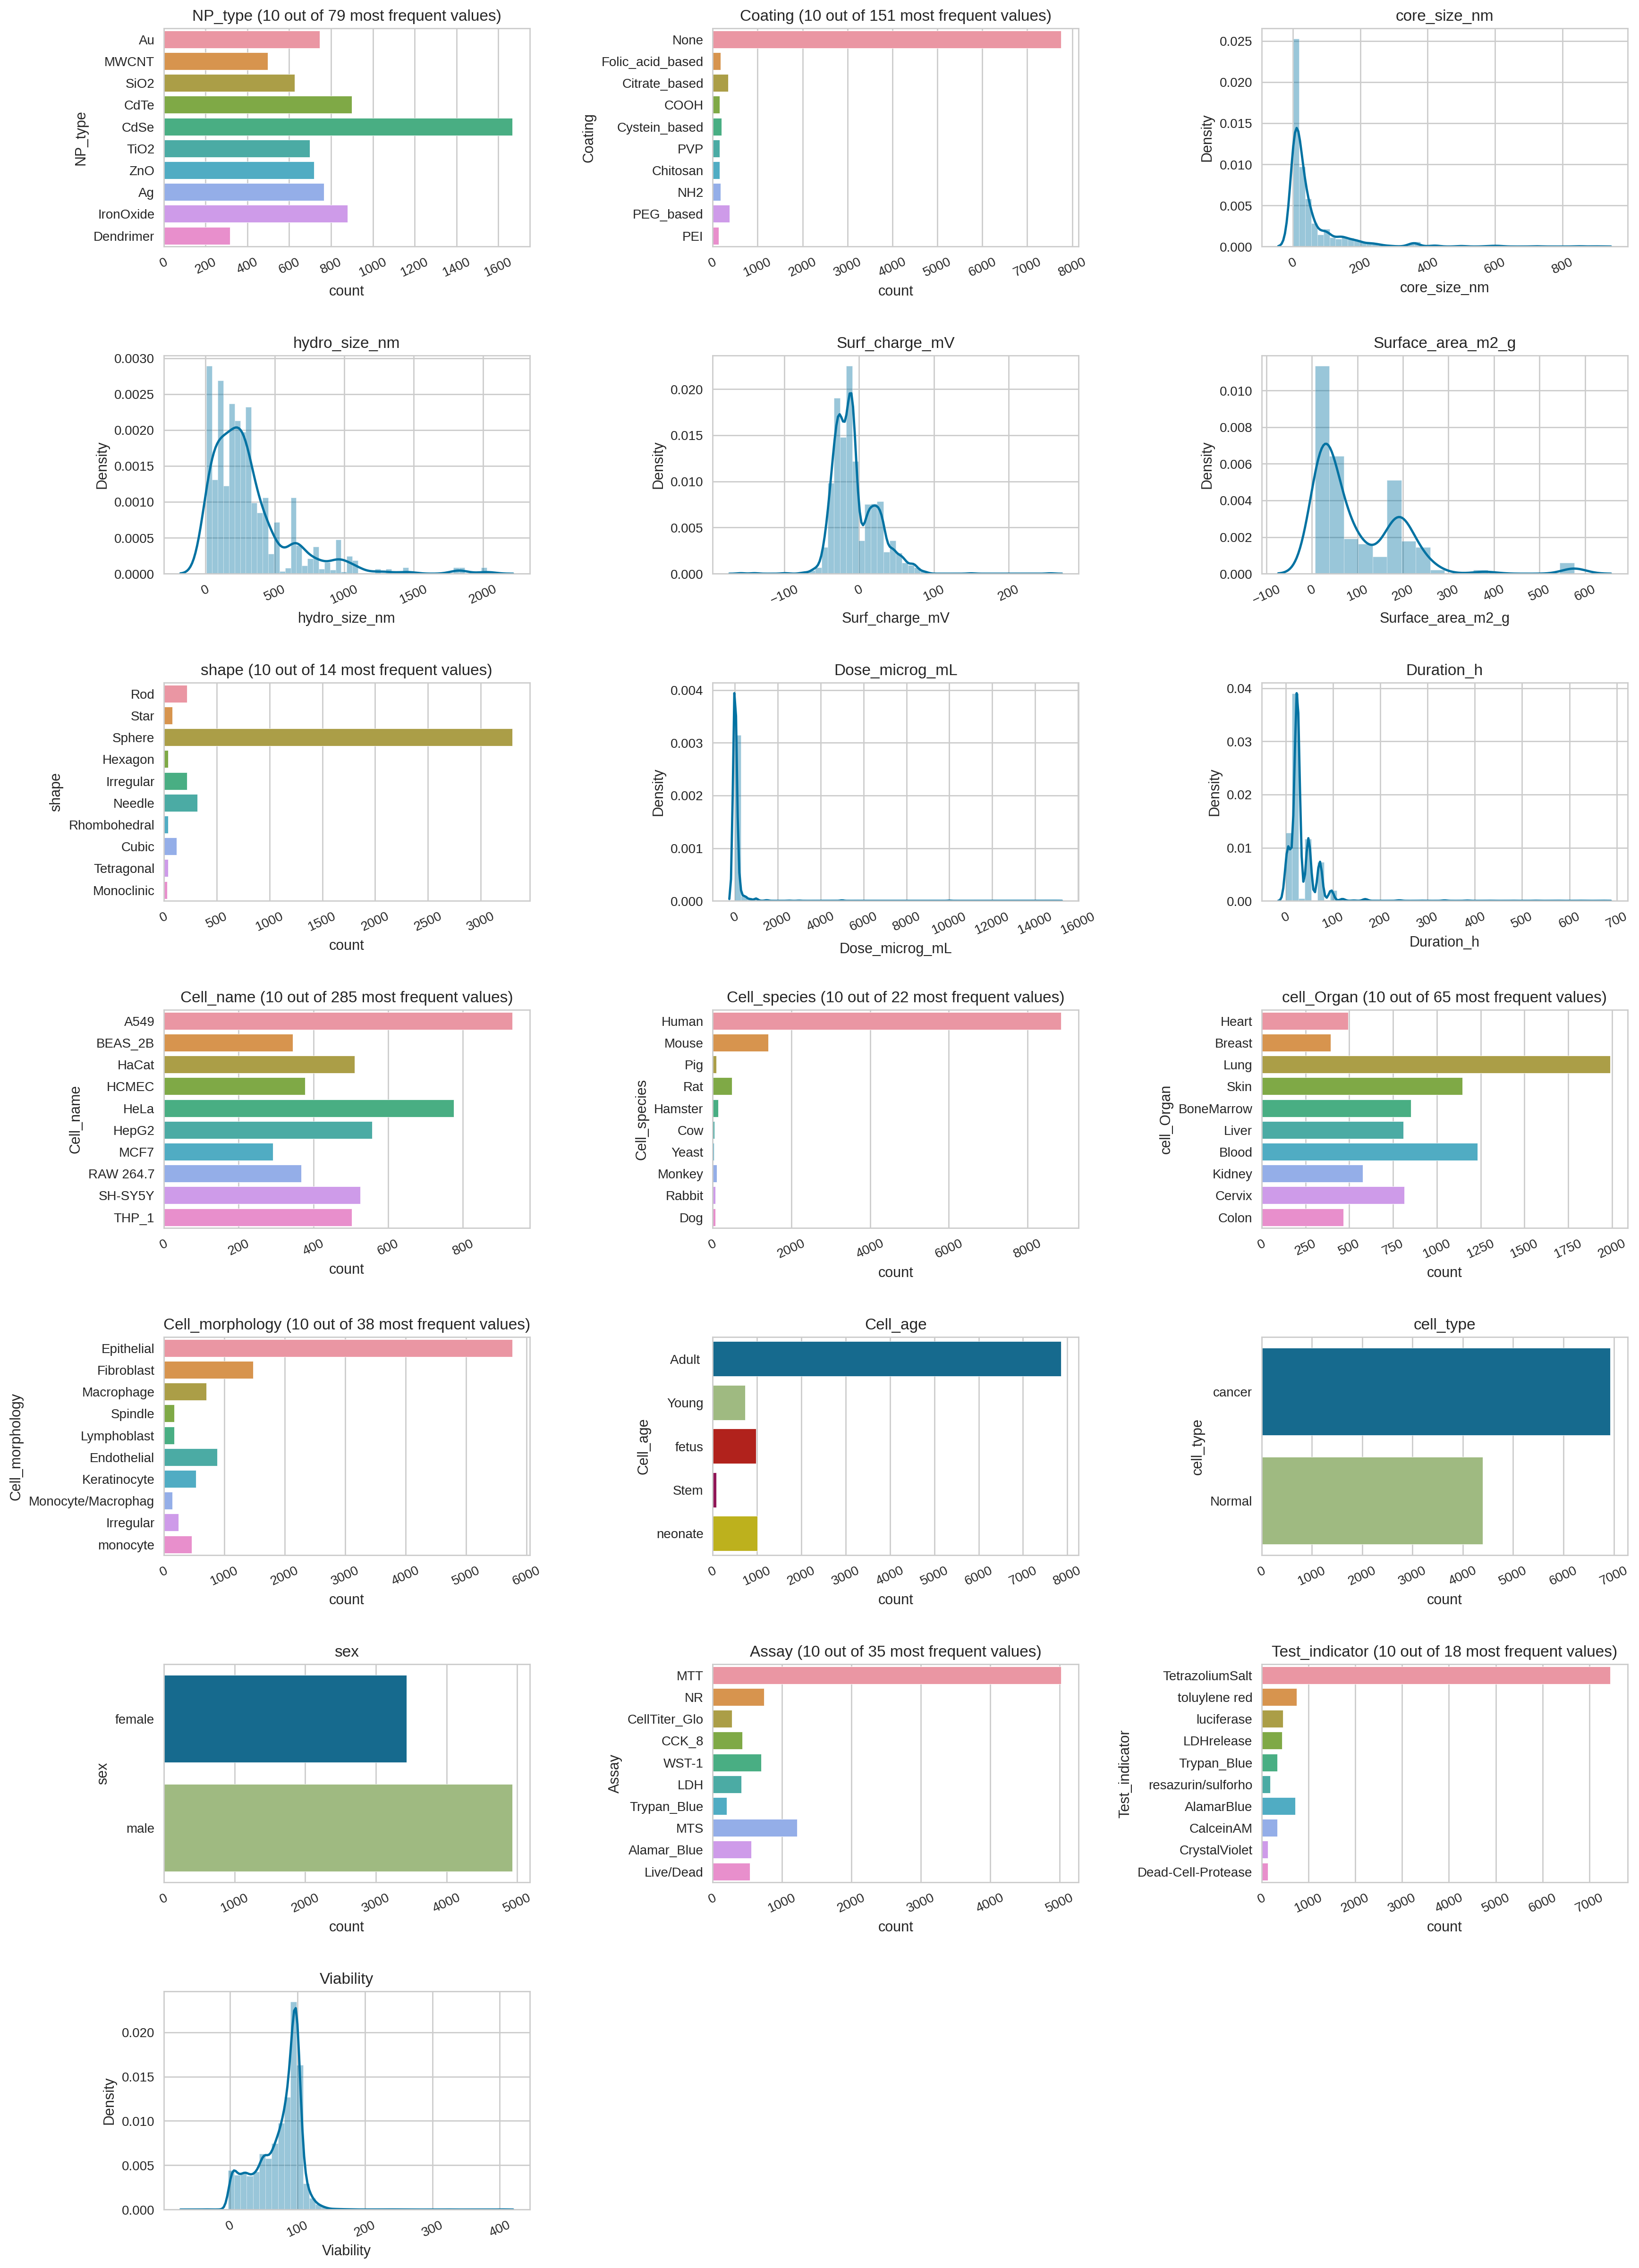

In [33]:
plot_distribution(data_df)

## Group NP types

In [34]:
data_df["nanomaterial_group"] = data_df["NP_type"]

In [35]:
metal_oxides = ["SiO2", "MgO", "TiO2", "ZnO", "Bi2O3", "CuO", "Cu2O", "Fe3O4", "IronOxide", "MnO", "ZrO2", "Co3O4", "CoO",
          "Mn2O3", "Ni2O3", "Al2O3", "Fe2O3", "In2O3", "La2O3", "NiO", "Sb2O3", "SnO2", "Y2O3", "CeO2", "CdO", "Dy2O3", 
          "Er2O3", "Eu2O3", "Gd2O3", "HfO2", "MnO2", "Nd2O3", "Sm2O3", "Yb2O3", "Cr2O3"]
carbon = ["Graphite", "Diamond", "C60", "C70", "Carbon"]
nanotubes = ["Nanotubes", "SWCNT", "MWCNT"]
quantum_dots = ['CdSe', 'CdTe', 'CdSeTe', 'CdZnS', 'CdS', 'CdTeS', 'CdHgTe', 'CdSeS', 'CdGeS', 'CdGdTe', 'CdZnSeS', 'QD', 'QDs']

In [36]:
combined_groups = list(metal_oxides + carbon + nanotubes + quantum_dots)

In [37]:
data_df.loc[data_df["NP_type"].isin(metal_oxides), "nanomaterial_group"] = "meta_oxide" 

In [38]:
data_df.loc[data_df["NP_type"].isin(carbon), "nanomaterial_group"] = "carbon" 

In [39]:
data_df.loc[data_df["NP_type"].isin(nanotubes), "nanomaterial_group"] = "nanotubes" 

In [40]:
data_df.loc[data_df["NP_type"].isin(quantum_dots), "nanomaterial_group"] = "quantum_dots" 

In [41]:
data_df.loc[~data_df["NP_type"].isin(combined_groups), "nanomaterial_group"] = "other" 

In [42]:
data_df['NP_type'][~data_df['NP_type'].isin(combined_groups)].unique()

array(['Au', 'Ag', 'Chitosan', 'Ni', 'PLGA', 'Polystyrene', 'SLN',
       'Hydroxyapatite', 'Mo', 'Alginate', 'Dendrimer', 'Liposomes',
       'WO3', 'Co', 'Pt', 'CuS', 'Bi', 'PTFE-PMMA', 'Cu', 'EudragitRL',
       'Se', 'Cr', 'Ti'], dtype=object)

In [43]:
data_df.sample(n=20)

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability,nanomaterial_group
7478,Carbon,None,21.00,NaN,NaN,NaN,Sphere,50.000000,24.0,Macrophages,Mouse,Peritoneal Cavity,Macrophage,Adult,Normal,NaN,WST-1,TetrazoliumSalt,94.92,carbon
291,Ag,Citrate_based,50.00,95.0,-35.00,NaN,Sphere,25.000000,24.0,A549,Human,Lung,Epithelial,Adult,cancer,male,MTS,TetrazoliumSalt,94.37,other
4046,CdSe,None,8.30,NaN,NaN,NaN,NaN,0.018000,4.0,HDF,Human,Skin,Fibroblast,Adult,Normal,NaN,Live/Dead,NaN,2.50,quantum_dots
7415,Ag,None,20.00,NaN,NaN,NaN,NaN,0.000189,24.0,LoVo,Human,Colon,Epithelial,Adult,cancer,male,CellTiterBlue,AlamarBlue,109.42,other
4880,CdSeS,None,4.70,NaN,NaN,NaN,NaN,0.050000,24.0,HeLa,Human,Cervix,Epithelial,Adult,cancer,female,Live/Dead,NaN,82.10,quantum_dots
1628,CuO,None,12.80,305.3,7.60,NaN,NaN,50.000000,NaN,BEAS_2B,Human,Lung,Epithelial,Adult,Normal,NaN,ATPLite,luciferase,31.70,meta_oxide
4789,CdSe,None,4.00,NaN,NaN,NaN,NaN,6.746878,48.0,HeLa,Human,Cervix,Epithelial,Adult,cancer,female,SRB,resazurin/sulforhodamine_B,78.40,quantum_dots
11542,MWCNT,None,12.50,NaN,NaN,177.57,NaN,25.000000,24.0,WI_38,Human,Lung,Fibroblast,fetus,cancer,female,WST-1,TetrazoliumSalt,69.53,nanotubes
3000,CdSe,Hypotonic,3.40,NaN,NaN,NaN,NaN,0.010000,0.0,H9C2,Rat,Heart,Myoblast,NaN,cancer,male,Live/Dead,NaN,90.32,quantum_dots
6518,IronOxide,Dextran,30.15,NaN,NaN,NaN,Sphere,60.000000,24.0,HUVEC,Human,Umbilical,Endothelial,fetus,Normal,NaN,CCK_8,TetrazoliumSalt,96.29,meta_oxide


# PyCaret

In [29]:
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

## Define data preparing scenarios

In [44]:
features_scenarios = list()

scenario1 = {}
scenario1["ID"] = 1
scenario1["ignore_features"] = ["NP_type", "Coating", "Cell_name"]
scenario1["high_cardinality_features"] = ["cell_Organ", "Cell_morphology", "Assay"]
scenario1["bin_numeric_features"] = ["Duration_h", "Dose_microg_mL"]

scenario2 = {}
scenario2["ID"] = 2
scenario2["ignore_features"] = ["NP_type", "Coating", "Cell_name"]
scenario2["high_cardinality_features"] = None
scenario2["bin_numeric_features"] = ["Duration_h", "Dose_microg_mL"]

scenario3 = {}
scenario3["ID"] = 3
scenario3["ignore_features"] = ["NP_type", "Coating", "Cell_name"]
scenario3["high_cardinality_features"] = ["cell_Organ", "Cell_morphology", "Assay"]
scenario3["bin_numeric_features"] = None

scenario4 = {}
scenario4["ID"] = 4
scenario4["ignore_features"] = ["NP_type", "Coating", "Cell_name"]
scenario4["high_cardinality_features"] = None
scenario4["bin_numeric_features"] = None

scenario5 = {}
scenario5["ID"] = 5
scenario5["ignore_features"] = ["nanomaterial_group", "Coating", "Cell_name"]
scenario5["high_cardinality_features"] = ["cell_Organ", "Cell_morphology", "Assay"]
scenario5["bin_numeric_features"] = ["Duration_h", "Dose_microg_mL"]

scenario6 = {}
scenario6["ID"] = 6
scenario6["ignore_features"] = ["nanomaterial_group", "Coating", "Cell_name"]
scenario6["high_cardinality_features"] = None
scenario6["bin_numeric_features"] = ["Duration_h", "Dose_microg_mL"]

scenario7 = {}
scenario7["ID"] = 7
scenario7["ignore_features"] = ["nanomaterial_group", "Coating", "Cell_name"]
scenario7["high_cardinality_features"] = ["cell_Organ", "Cell_morphology", "Assay"]
scenario7["bin_numeric_features"] = None

scenario8 = {}
scenario8["ID"] = 8
scenario8["ignore_features"] = ["nanomaterial_group", "Coating", "Cell_name"]
scenario8["high_cardinality_features"] = None
scenario8["bin_numeric_features"] = None

features_scenarios.append(scenario1)
features_scenarios.append(scenario2)
features_scenarios.append(scenario3)
features_scenarios.append(scenario4)
features_scenarios.append(scenario5)
features_scenarios.append(scenario6)
features_scenarios.append(scenario7)
features_scenarios.append(scenario8)


imputation_scenarios = list()

scenario1 = {}
scenario1["ID"] = 1
scenario1["imputation_type"] = "simple"
scenario1["numeric_imputation"] = "median"

scenario2 = {}
scenario2["ID"] = 2
scenario2["imputation_type"] = "simple"
scenario2["numeric_imputation"] = "mean"

scenario3 = {}
scenario3["ID"] = 3
scenario3["imputation_type"] = "iterative"
scenario3["numeric_imputation"] = "mean"

imputation_scenarios.append(scenario1)
imputation_scenarios.append(scenario2)
imputation_scenarios.append(scenario3)



preprocess_scenarios = list()

scenario1 = {}
scenario1["ID"] = 1
scenario1["normalize"] = True
scenario1["remove_outliers"] = True

scenario2 = {}
scenario2["ID"] = 2
scenario2["normalize"] = True
scenario2["remove_outliers"] = False

scenario3 = {}
scenario3["ID"] = 3
scenario3["normalize"] = False
scenario3["remove_outliers"] = True

scenario4 = {}
scenario4["ID"] = 4
scenario4["normalize"] = False
scenario4["remove_outliers"] = False

preprocess_scenarios.append(scenario1)
preprocess_scenarios.append(scenario2)
preprocess_scenarios.append(scenario3)
preprocess_scenarios.append(scenario4)

In [45]:
data_df.columns

Index(['NP_type', 'Coating', 'core_size_nm', 'hydro_size_nm', 'Surf_charge_mV',
       'Surface_area_m2_g', 'shape', 'Dose_microg_mL', 'Duration_h',
       'Cell_name', 'Cell_species', 'cell_Organ', 'Cell_morphology',
       'Cell_age', 'cell_type', 'sex', 'Assay', 'Test_indicator', 'Viability',
       'nanomaterial_group'],
      dtype='object')

## Run PyCaret for all the scenarios 96 in total (8 X 3 X 4)

In [33]:
i = 0
j = 0
k = 0

for features_scenario in features_scenarios:
    i = features_scenario["ID"] 
    for imputation_scenario in imputation_scenarios:
        j = imputation_scenario["ID"]
        for preprocess_scenario in preprocess_scenarios:
            k = preprocess_scenario["ID"]
                                
            print(imputation_scenario["imputation_type"])
            print(imputation_scenario["numeric_imputation"])
            print(features_scenario["ignore_features"])
            print(features_scenario["bin_numeric_features"])
            print(features_scenario["high_cardinality_features"])
            print(preprocess_scenario["normalize"])
            print(preprocess_scenario["remove_outliers"])

            stup = setup(data = data_df, target = 'Viability', 

                imputation_type = imputation_scenario["imputation_type"], #default
                numeric_imputation = imputation_scenario["numeric_imputation"], #default: mean

                categorical_imputation = "constant", #default: constant
                iterative_imputation_iters = 5, #default: 5
                numeric_iterative_imputer = "lightgbm",
                categorical_iterative_imputer = "lightgbm",

                ignore_features = features_scenario["ignore_features"],
                bin_numeric_features = features_scenario["bin_numeric_features"],
                high_cardinality_features = features_scenario["high_cardinality_features"],

                high_cardinality_method = "frequency", #default: frequency
                handle_unknown_categorical = True, #default
                unknown_categorical_method = "least_frequent", #default

                normalize = preprocess_scenario["normalize"], #default: False
                remove_outliers= preprocess_scenario["remove_outliers"], #default: False

                outliers_threshold = 0.05, #default

                transformation= False, #default
                transformation_method = 'yeo-johnson', #default
                transform_target = False, 
                combine_rare_levels = False,
                rare_level_threshold = 0.1, #default: 0.1

                remove_multicollinearity = False, #default 
                multicollinearity_threshold = 0.9, #default

                ignore_low_variance = True, 

                feature_interaction = False, 
                feature_ratio = False,
                polynomial_features = False, 
                trigonometry_features = False,

                train_size=0.8,

                # don't change the following
                session_id = 123,
                use_gpu=False,
                log_experiment = False,
                silent=True,
                experiment_name = 'nanosafety')
            
            set_config('seed', 123456)

            best = compare_models(exclude = ['par', 'lar', 'llar', 'en', 'lasso', 'xgboost', 'catboost',
                             'ada', 'omp', 'huber', 'br', 'ridge',
                            'dt', 'knn', 'lr'], n_select = 3)

            results_df = pull()

            results_df = results_df.reset_index(level=0)

            results_df.to_csv("output/results/" + "-".join([str(i), str(j), str(k)])+".tsv", 
                                                         index=False, encoding="utf-8", sep="\t")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,12.3357,366.7953,19.0993,0.6441,0.5182,0.9369,2.0530
et,Extra Trees Regressor,11.5142,399.8183,19.9098,0.6127,0.5035,0.7844,2.4690
lightgbm,Light Gradient Boosting Machine,15.4983,464.2621,21.5267,0.5498,0.6159,1.3900,0.0740
gbr,Gradient Boosting Regressor,20.1850,674.9613,25.9669,0.3453,0.7455,2.2811,0.4810
dummy,Dummy Regressor,25.9732,1032.2711,32.1119,-0.0007,0.8655,4.3553,0.0170


## Aggregate ML training reports from 96 experiments and order by R2 (descending)

In [46]:
results_list = os.listdir("output/results")

In [47]:
os.path.splitext(os.path.basename("output/results/"+results_list[0]))[0]

'1-1-1'

In [48]:
li = []

for result_file in results_list:
    
    scenario = os.path.splitext(os.path.basename("output/results/"+result_file))[0]
    df = pd.read_csv("output/results/"+result_file, encoding="utf-8", index_col=None, header=0, sep="\t")
    df['scenario'] = scenario
    li.append(df)

In [49]:
final_df = pd.concat(li, axis=0, ignore_index=True)
final_df = final_df.reset_index(drop=True)

print(final_df.shape)

(480, 10)


In [50]:
final_df.dtypes

index        object
Model        object
MAE         float64
MSE         float64
RMSE        float64
R2          float64
RMSLE       float64
MAPE        float64
TT (Sec)    float64
scenario     object
dtype: object

In [51]:
final_df.head()

,index,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),scenario
0,rf,Random Forest Regressor,16.3415,556.4931,23.5743,0.4639,0.6120,1.5299,0.840,1-1-1
1,lightgbm,Light Gradient Boosting Machine,18.0641,591.9795,24.3183,0.4301,0.6706,1.8627,0.047,1-1-1
2,et,Extra Trees Regressor,16.7810,616.9763,24.8230,0.4052,0.6428,1.4637,0.577,1-1-1
3,gbr,Gradient Boosting Regressor,21.5255,764.5864,27.6308,0.2655,0.7614,2.4047,0.140,1-1-1
4,dummy,Dummy Regressor,26.0661,1041.7730,32.2577,-0.0008,0.8686,4.4506,0.015,1-1-1


In [52]:
final_df = final_df.sort_values(by=['R2'], ascending=False)

In [53]:
final_df.head(n=20)

,index,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),scenario
460,et,Extra Trees Regressor,11.3693,354.9100,18.8121,0.6574,0.4901,0.7791,1.765,8-3-1
461,rf,Random Forest Regressor,12.3124,355.7842,18.8293,0.6569,0.5099,1.0110,1.679,8-3-1
405,et,Extra Trees Regressor,11.5559,358.8068,18.9215,0.6514,0.5075,0.7966,1.505,7-3-2
400,et,Extra Trees Regressor,11.6601,366.5237,19.1226,0.6466,0.5076,0.8222,1.084,7-3-1
470,rf,Random Forest Regressor,12.3745,367.8435,19.1252,0.6465,0.5161,1.0653,1.582,8-3-3
475,rf,Random Forest Regressor,12.3357,366.7953,19.0993,0.6441,0.5182,0.9369,2.053,8-3-4
465,et,Extra Trees Regressor,11.6822,369.3993,19.1966,0.6413,0.5140,0.8418,2.452,8-3-2
401,rf,Random Forest Regressor,12.6659,373.2708,19.2990,0.6402,0.5228,0.9682,1.212,7-3-1
410,rf,Random Forest Regressor,12.4441,375.4340,19.3233,0.6389,0.5075,1.0005,1.318,7-3-3
375,rf,Random Forest Regressor,12.2142,372.7585,19.2615,0.6387,0.5140,0.8953,1.150,7-1-4


# The Universal Model

#### Best scenario from the previous table is: 8-3-1

In [54]:
best_scenario = [8 , 3, 1]

In [55]:
sc_ignore_features = features_scenarios[best_scenario[0]-1]["ignore_features"]
sc_bin_numeric_features = features_scenarios[best_scenario[0]-1]["bin_numeric_features"]
sc_high_cardinality_features = features_scenarios[best_scenario[0]-1]["high_cardinality_features"]

print(sc_ignore_features)
print(sc_bin_numeric_features)
print(sc_high_cardinality_features)


sc_imputation_type = imputation_scenarios[best_scenario[1]-1]["imputation_type"]
sc_numeric_imputation = imputation_scenarios[best_scenario[1]-1]["numeric_imputation"]

print(sc_imputation_type)
print(sc_numeric_imputation)

sc_normalize = preprocess_scenarios[best_scenario[2]-1]["normalize"]
sc_remove_outliers = preprocess_scenarios[best_scenario[2]-1]["remove_outliers"]

print(sc_normalize)
print(sc_remove_outliers)

['nanomaterial_group', 'Coating', 'Cell_name']
None
None
iterative
mean
True
True


## Try the best preprocessing combination

In [61]:
stup = setup(data = data_df, target = 'Viability', 
                
        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        train_size=0.8,

        # don't change the following
        session_id = 123,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'nanosafety')

set_config('seed', 123)

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(11423, 20)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8681, 185)"


In [62]:
save_config('config/universal-model-config.cfg')

In [63]:
best_mdl = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,11.5096,361.5581,18.9845,0.6519,0.4918,0.7140,1.7680
rf,Random Forest Regressor,12.4908,364.2208,19.0521,0.6492,0.5149,1.0040,1.6830
xgboost,Extreme Gradient Boosting,13.8952,395.9929,19.8732,0.6186,0.5500,1.1845,1.0430
catboost,CatBoost Regressor,14.6246,418.8788,20.4452,0.5966,0.5809,1.3346,5.2200
lightgbm,Light Gradient Boosting Machine,15.3880,455.7669,21.3320,0.5610,0.6027,1.4241,0.0670
dt,Decision Tree Regressor,14.6730,582.9632,24.1039,0.4378,0.5892,1.1256,0.0450
knn,K Neighbors Regressor,17.0011,597.3285,24.4141,0.4234,0.6342,1.7379,0.1320
gbr,Gradient Boosting Regressor,19.9688,666.5648,25.8007,0.3586,0.7365,2.3169,0.3440
ridge,Ridge Regression,21.7982,791.5996,28.1250,0.2374,0.7875,3.2496,0.0190
br,Bayesian Ridge,21.8595,792.3858,28.1379,0.2369,0.7903,3.2988,0.1320


In [69]:
save_model(best_mdl[0], 'models/universal-model-top1.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
    

In [70]:
best_mdl_1 = best_mdl[0]

In [71]:
predictions_heldout_set = predict_model(best_mdl_1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,13.2099,405.4924,20.1368,0.6069,0.5851,2.4756


## Plot learning and error of the top model

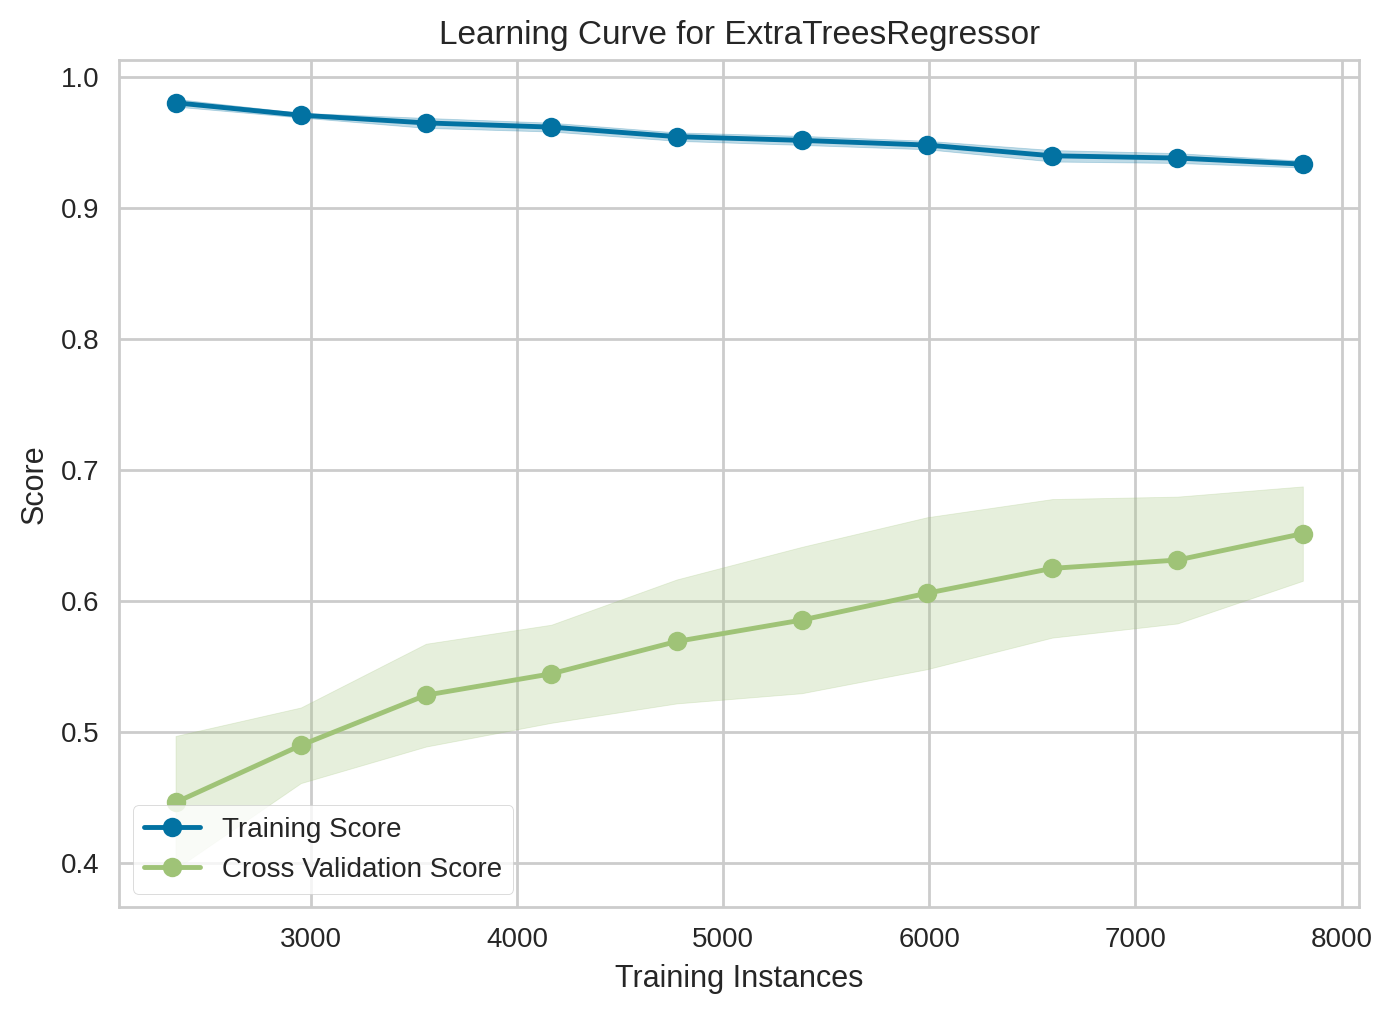

In [76]:
plot_model(best_mdl_1, plot = 'learning')

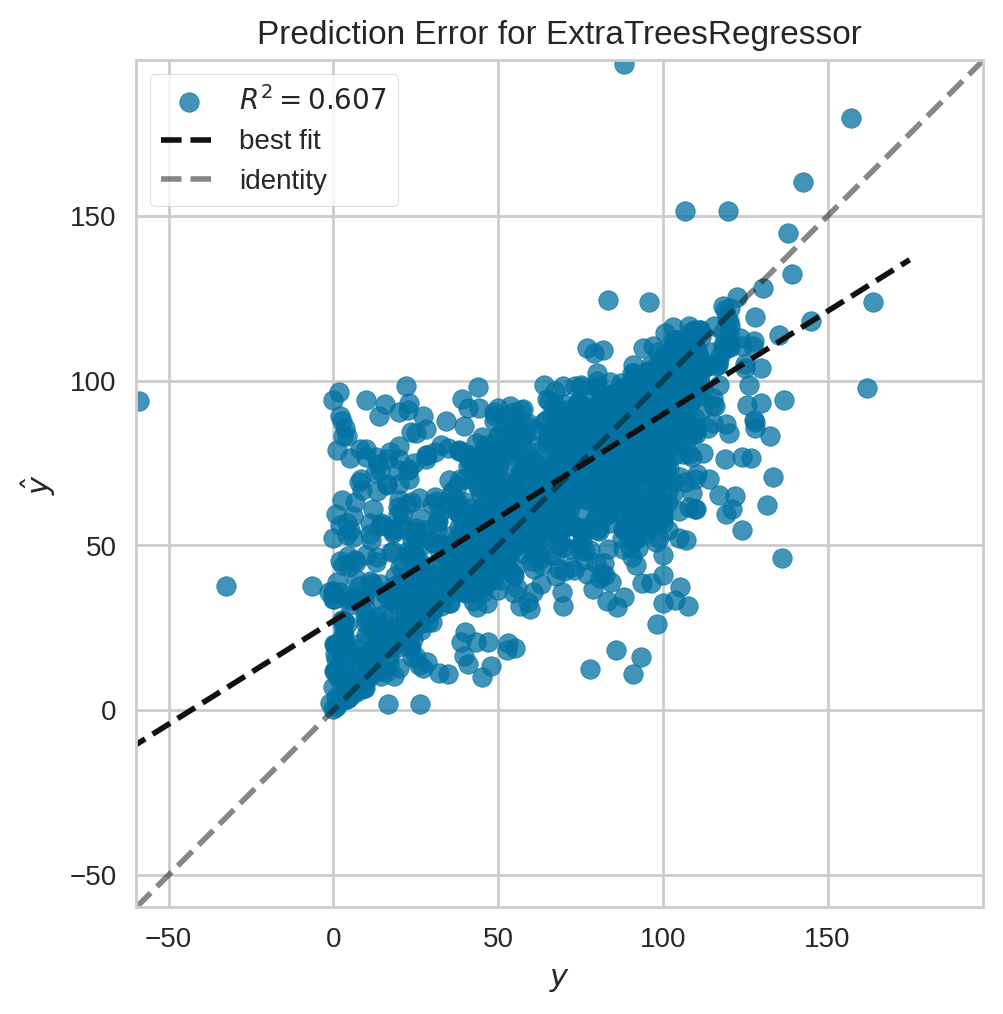

In [77]:
plot_model(best_mdl_1, plot = 'error')

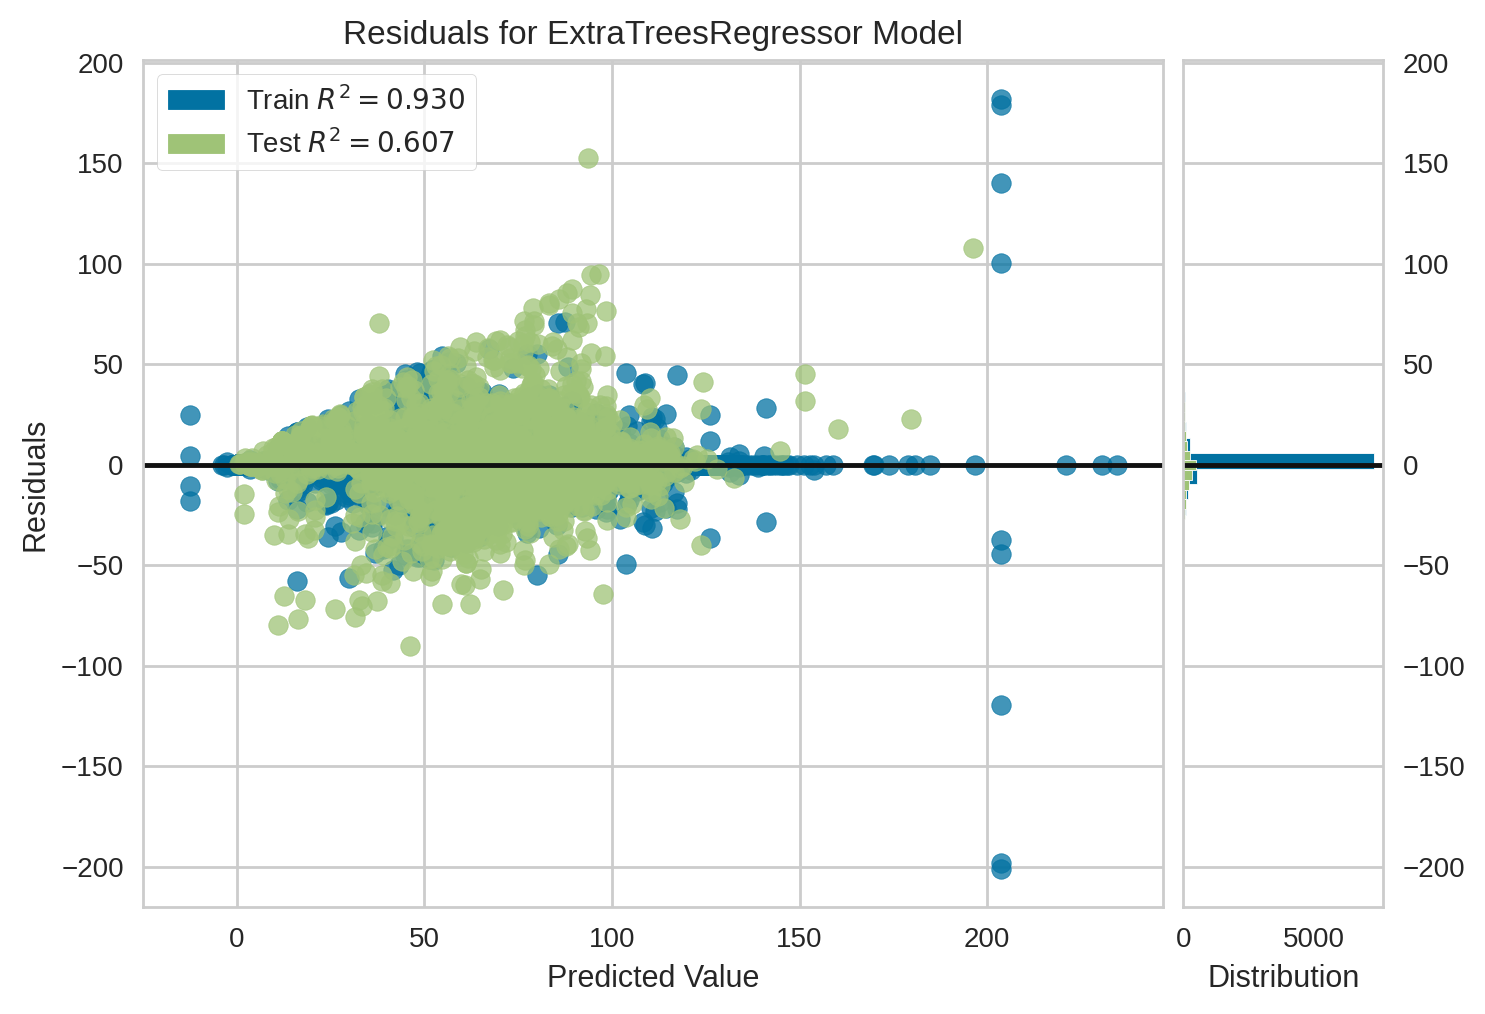

In [78]:
plot_model(best_mdl_1, plot = 'residuals')

## Plot feature importance for the top model

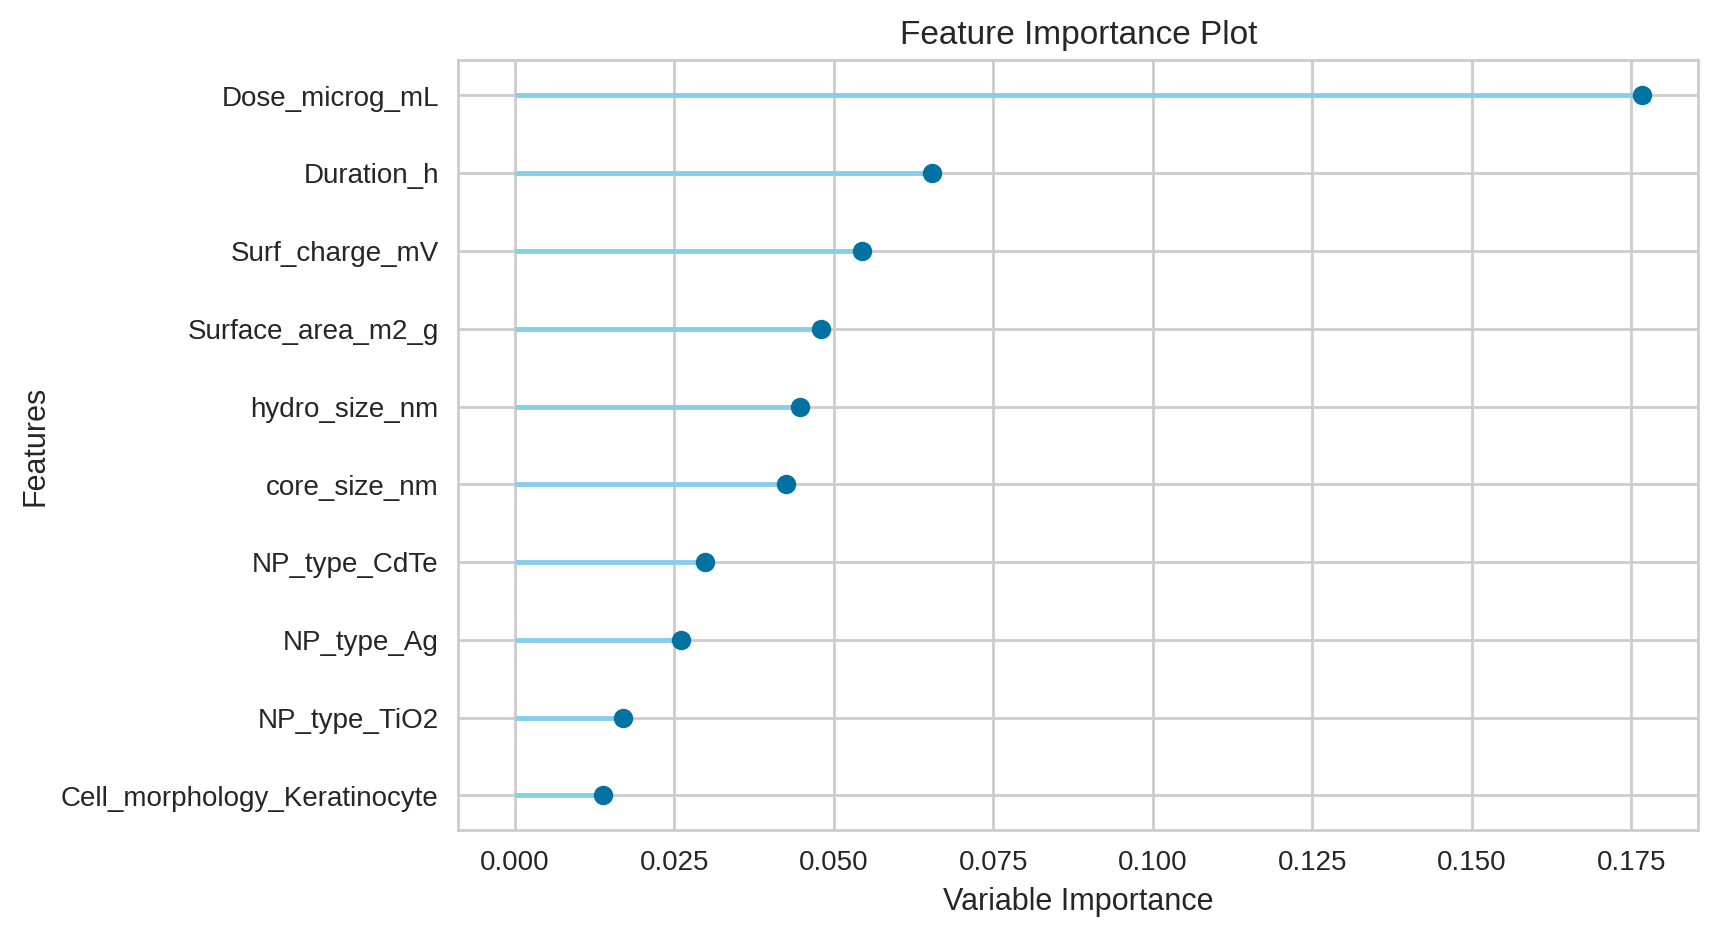

In [80]:
plot_model(best_mdl_1, plot = 'feature')

## Finalize the model and apply on the test set

In [73]:
final_universal_model = finalize_model(best_mdl_1)

In [74]:
final_heldout_set = predict_model(final_universal_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.8258,64.9357,8.0583,0.9371,0.1975,0.1046


In [75]:
final_test_heldout_set = predict_model(final_universal_model, data=data_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,30.7023,2697.7117,51.9395,0.0183,1.0848,6.4840


In [81]:
save_model(final_universal_model, 'models/universal-model-final.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
    

# Train a model for metal oxide nanomaterials

## Use best scenario 8-3-1

In [32]:
best_scenario = [8 , 3, 1]

In [33]:
sc_ignore_features = features_scenarios[best_scenario[0]-1]["ignore_features"]
sc_bin_numeric_features = features_scenarios[best_scenario[0]-1]["bin_numeric_features"]
sc_high_cardinality_features = features_scenarios[best_scenario[0]-1]["high_cardinality_features"]

print(sc_ignore_features)
print(sc_bin_numeric_features)
print(sc_high_cardinality_features)


sc_imputation_type = imputation_scenarios[best_scenario[1]-1]["imputation_type"]
sc_numeric_imputation = imputation_scenarios[best_scenario[1]-1]["numeric_imputation"]

print(sc_imputation_type)
print(sc_numeric_imputation)

sc_normalize = preprocess_scenarios[best_scenario[2]-1]["normalize"]
sc_remove_outliers = preprocess_scenarios[best_scenario[2]-1]["remove_outliers"]

print(sc_normalize)
print(sc_remove_outliers)

['nanomaterial_group', 'Coating', 'Cell_name']
None
None
iterative
mean
True
True


In [34]:
data_oxide_df = data_df[data_df['nanomaterial_group'] == 'meta_oxide']

In [35]:
data_oxide_df.shape

(4151, 20)

In [36]:
data_oxide_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability,nanomaterial_group
86,SiO2,None,NaN,229.5,-21.77,NaN,Sphere,8.0,24.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CCK_8,TetrazoliumSalt,101.06,meta_oxide
87,SiO2,None,NaN,229.5,-21.77,NaN,Sphere,16.0,24.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CCK_8,TetrazoliumSalt,102.73,meta_oxide
88,SiO2,None,NaN,229.5,-21.77,NaN,Sphere,32.0,24.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CCK_8,TetrazoliumSalt,103.64,meta_oxide
89,SiO2,None,NaN,229.5,-21.77,NaN,Sphere,64.0,24.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CCK_8,TetrazoliumSalt,106.22,meta_oxide
90,SiO2,None,NaN,229.5,-21.77,NaN,Sphere,128.0,24.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CCK_8,TetrazoliumSalt,72.99,meta_oxide


In [37]:
stup_mo = setup(data = data_oxide_df, target = 'Viability', 
                    
        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        # don't change the following
        session_id = 123,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'nanosafety')

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(4151, 20)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2759, 102)"


In [38]:
best_metal_oxide_mdl = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,11.3665,344.4874,18.2581,0.6713,0.4550,1.1314,3.3320
lightgbm,Light Gradient Boosting Machine,11.8428,361.5139,18.7544,0.6555,0.4664,1.0637,0.0450
xgboost,Extreme Gradient Boosting,10.5699,359.4883,18.5562,0.6534,0.4245,0.8915,0.2360
rf,Random Forest Regressor,10.7832,377.6272,19.0220,0.6374,0.4336,1.0978,0.3400
et,Extra Trees Regressor,9.7490,397.3345,19.3153,0.6138,0.4120,0.9341,0.3050
gbr,Gradient Boosting Regressor,16.0390,534.0644,22.9214,0.4888,0.5765,1.5931,0.0890
dt,Decision Tree Regressor,12.1631,540.6018,22.7221,0.4736,0.4856,1.0391,0.0200
knn,K Neighbors Regressor,16.5799,632.1073,25.0496,0.3805,0.5944,2.0132,0.0150
br,Bayesian Ridge,19.6590,753.9911,27.3193,0.2720,0.6514,2.3530,0.0210
ridge,Ridge Regression,19.6312,755.2611,27.3537,0.2695,0.6480,2.3402,0.0150


In [40]:
save_model(best_metal_oxide_mdl, 'models/group-model-metal-oxides-top1-catboost.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                          target='Viability')),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Viability')),
                 ('fix_perfect', Remove_100(target='Viability')),
                 ('clean_names', Clean_Colum_Names()),
      

## Plot feature importance of the metal-oxide group model

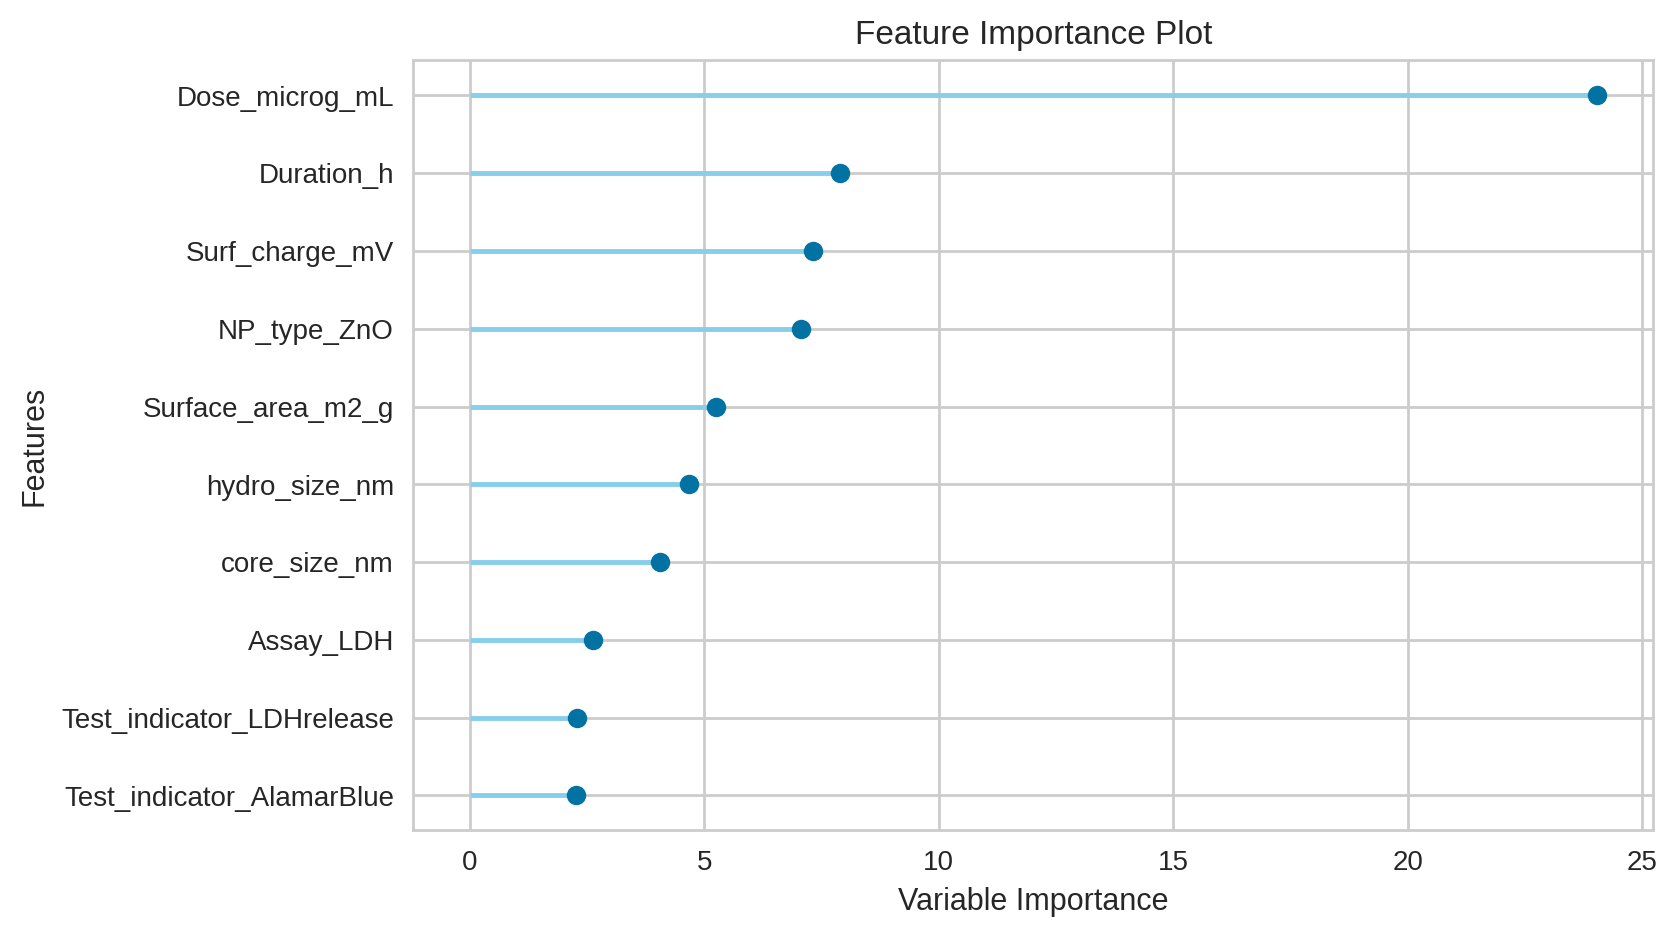

In [42]:
plot_model(best_metal_oxide_mdl, plot = 'feature')

# Train a model for carbon-based nanomaterials

## Use best scenario 8-3-1

In [44]:
best_scenario = [8 , 3, 1]

In [45]:
sc_ignore_features = features_scenarios[best_scenario[0]-1]["ignore_features"]
sc_bin_numeric_features = features_scenarios[best_scenario[0]-1]["bin_numeric_features"]
sc_high_cardinality_features = features_scenarios[best_scenario[0]-1]["high_cardinality_features"]

print(sc_ignore_features)
print(sc_bin_numeric_features)
print(sc_high_cardinality_features)


sc_imputation_type = imputation_scenarios[best_scenario[1]-1]["imputation_type"]
sc_numeric_imputation = imputation_scenarios[best_scenario[1]-1]["numeric_imputation"]

print(sc_imputation_type)
print(sc_numeric_imputation)

sc_normalize = preprocess_scenarios[best_scenario[2]-1]["normalize"]
sc_remove_outliers = preprocess_scenarios[best_scenario[2]-1]["remove_outliers"]

print(sc_normalize)
print(sc_remove_outliers)

['nanomaterial_group', 'Coating', 'Cell_name']
None
None
iterative
mean
True
True


In [46]:
data_carbon_df = data_df[data_df['nanomaterial_group'] == 'carbon']

In [47]:
data_carbon_df.shape

(218, 20)

In [48]:
data_carbon_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability,nanomaterial_group
1965,Diamond,None,4.0,NaN,-35.6,NaN,Sphere,20.0,2.0,C3A,Human,Liver,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,113.14,carbon
1966,Diamond,None,4.0,NaN,-35.6,NaN,Sphere,50.0,2.0,C3A,Human,Liver,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,118.48,carbon
1967,Diamond,None,4.0,NaN,-35.6,NaN,Sphere,100.0,2.0,C3A,Human,Liver,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,113.14,carbon
1968,Diamond,None,4.0,NaN,-35.6,NaN,Sphere,20.0,24.0,C3A,Human,Liver,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,100.85,carbon
1969,Diamond,None,4.0,NaN,-35.6,NaN,Sphere,50.0,24.0,C3A,Human,Liver,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,106.13,carbon


In [49]:
stup_cb = setup(data = data_carbon_df, target = 'Viability', 
                    
        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        # don't change the following
        session_id = 123,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'nanosafety')

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(218, 20)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,11
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(144, 37)"


In [50]:
best_carbon_mdl = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,7.2621,126.8457,10.9576,0.6407,0.2373,3.8083,0.0580
xgboost,Extreme Gradient Boosting,7.3165,124.3220,10.9209,0.6344,0.2443,5.2341,0.0600
catboost,CatBoost Regressor,8.0533,138.0614,11.4210,0.6045,0.2686,16.6989,1.0720
gbr,Gradient Boosting Regressor,8.8686,174.7517,12.7031,0.5387,0.3040,29.7523,0.0090
rf,Random Forest Regressor,9.0289,172.1022,12.6783,0.5313,0.2941,18.0676,0.0750
dt,Decision Tree Regressor,8.9499,201.7664,13.3247,0.4446,0.2629,3.8405,0.0050
ada,AdaBoost Regressor,12.8589,260.6785,15.8971,0.2510,0.3107,9.7317,0.0160
lightgbm,Light Gradient Boosting Machine,12.0552,275.9918,16.2708,0.2306,0.3518,44.4131,0.0130
knn,K Neighbors Regressor,11.7690,271.5499,16.1757,0.2181,0.3481,39.2429,0.0060
br,Bayesian Ridge,12.0399,294.2047,16.8002,0.2051,0.3620,49.6112,0.0050


In [51]:
save_model(best_carbon_mdl, 'models/group-model-carbon-based-top1-et.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
    

## Plot feature importance of the carbon-based group model

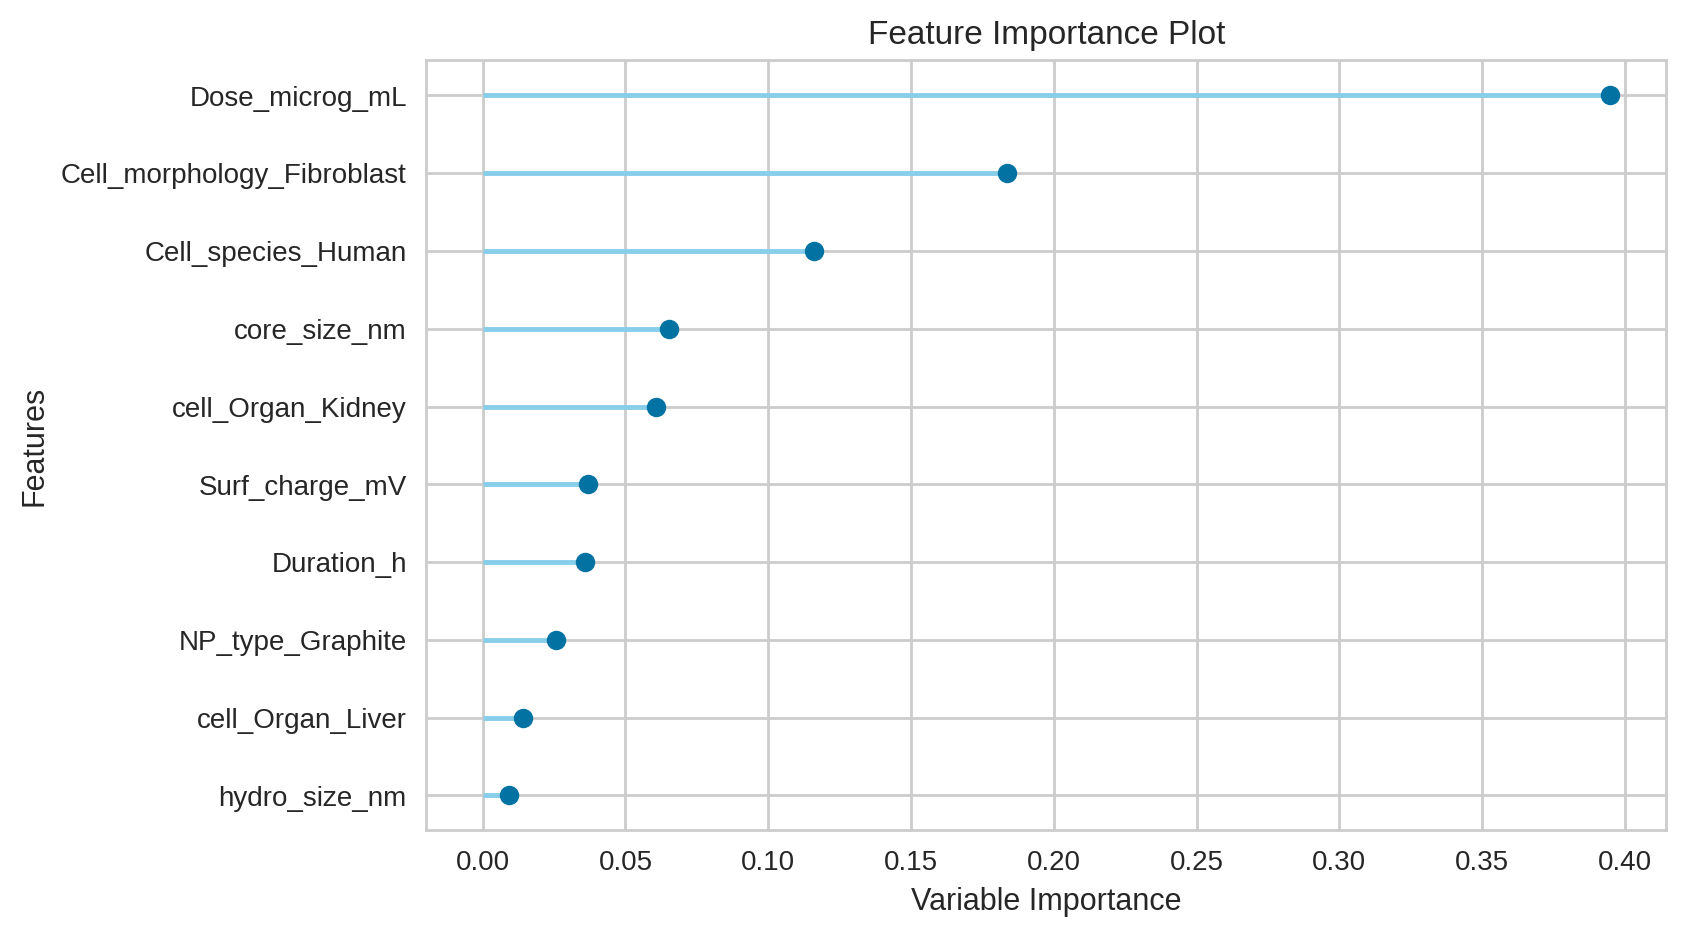

In [54]:
plot_model(best_carbon_mdl, plot = 'feature')

# Train a model for nanotube nanomaterials

## Use best scenario 8-3-1

In [55]:
best_scenario = [8 , 3, 1]

In [56]:
sc_ignore_features = features_scenarios[best_scenario[0]-1]["ignore_features"]
sc_bin_numeric_features = features_scenarios[best_scenario[0]-1]["bin_numeric_features"]
sc_high_cardinality_features = features_scenarios[best_scenario[0]-1]["high_cardinality_features"]

print(sc_ignore_features)
print(sc_bin_numeric_features)
print(sc_high_cardinality_features)


sc_imputation_type = imputation_scenarios[best_scenario[1]-1]["imputation_type"]
sc_numeric_imputation = imputation_scenarios[best_scenario[1]-1]["numeric_imputation"]

print(sc_imputation_type)
print(sc_numeric_imputation)

sc_normalize = preprocess_scenarios[best_scenario[2]-1]["normalize"]
sc_remove_outliers = preprocess_scenarios[best_scenario[2]-1]["remove_outliers"]

print(sc_normalize)
print(sc_remove_outliers)

['nanomaterial_group', 'Coating', 'Cell_name']
None
None
iterative
mean
True
True


In [57]:
data_nanotube_df = data_df[data_df['nanomaterial_group'] == 'nanotubes']

In [58]:
data_nanotube_df.shape

(676, 20)

In [59]:
data_nanotube_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability,nanomaterial_group
30,MWCNT,None,47.87,NaN,NaN,243.38,NaN,7.8,48.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CellTiter_Glo,luciferase,96.50,nanotubes
31,MWCNT,None,47.87,NaN,NaN,243.38,NaN,0.0,48.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CellTiter_Glo,luciferase,100.00,nanotubes
32,MWCNT,None,47.87,NaN,NaN,243.38,NaN,3.9,48.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CellTiter_Glo,luciferase,103.95,nanotubes
33,MWCNT,None,47.87,NaN,NaN,243.38,NaN,15.6,48.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CellTiter_Glo,luciferase,95.13,nanotubes
34,MWCNT,None,47.87,NaN,NaN,243.38,NaN,31.3,48.0,16HBE14,Human,Heart,Epithelial,Young,Normal,male,CellTiter_Glo,luciferase,88.02,nanotubes


In [60]:
stup_nt = setup(data = data_nanotube_df, target = 'Viability', 
                    
        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        # don't change the following
        session_id = 123,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'nanosafety')

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(676, 20)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(449, 42)"


In [61]:
best_nanotube_mdl = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,7.3065,141.6857,11.5497,0.8608,0.2914,0.3315,1.8980
lightgbm,Light Gradient Boosting Machine,8.1553,159.1403,12.3444,0.8516,0.3196,0.5295,0.0180
xgboost,Extreme Gradient Boosting,7.8799,165.3637,12.5033,0.8415,0.2962,0.3145,0.0850
rf,Random Forest Regressor,8.0444,170.1892,12.6626,0.8396,0.3212,0.4073,0.0910
gbr,Gradient Boosting Regressor,9.1104,178.7227,13.1532,0.8340,0.4024,0.7382,0.0180
et,Extra Trees Regressor,8.2022,186.9905,13.1997,0.8098,0.3294,0.3487,0.0710
knn,K Neighbors Regressor,11.4795,288.1280,16.7595,0.7414,0.3988,0.5826,0.0070
dt,Decision Tree Regressor,10.3020,301.6777,16.7010,0.7165,0.4244,0.4954,0.0060
br,Bayesian Ridge,13.9187,330.8471,17.9386,0.7154,0.8538,4.2504,0.0050
ridge,Ridge Regression,13.9060,330.0042,17.9276,0.7150,0.8577,4.3209,0.0050


In [62]:
save_model(best_nanotube_mdl, 'models/group-model-nanotube-top1-catboost.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                          target='Viability')),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Viability')),
                 ('fix_perfect', Remove_100(target='Viability')),
                 ('clean_names', Clean_Colum_Names()),
      

## Plot feature importance of the nanotubes group model

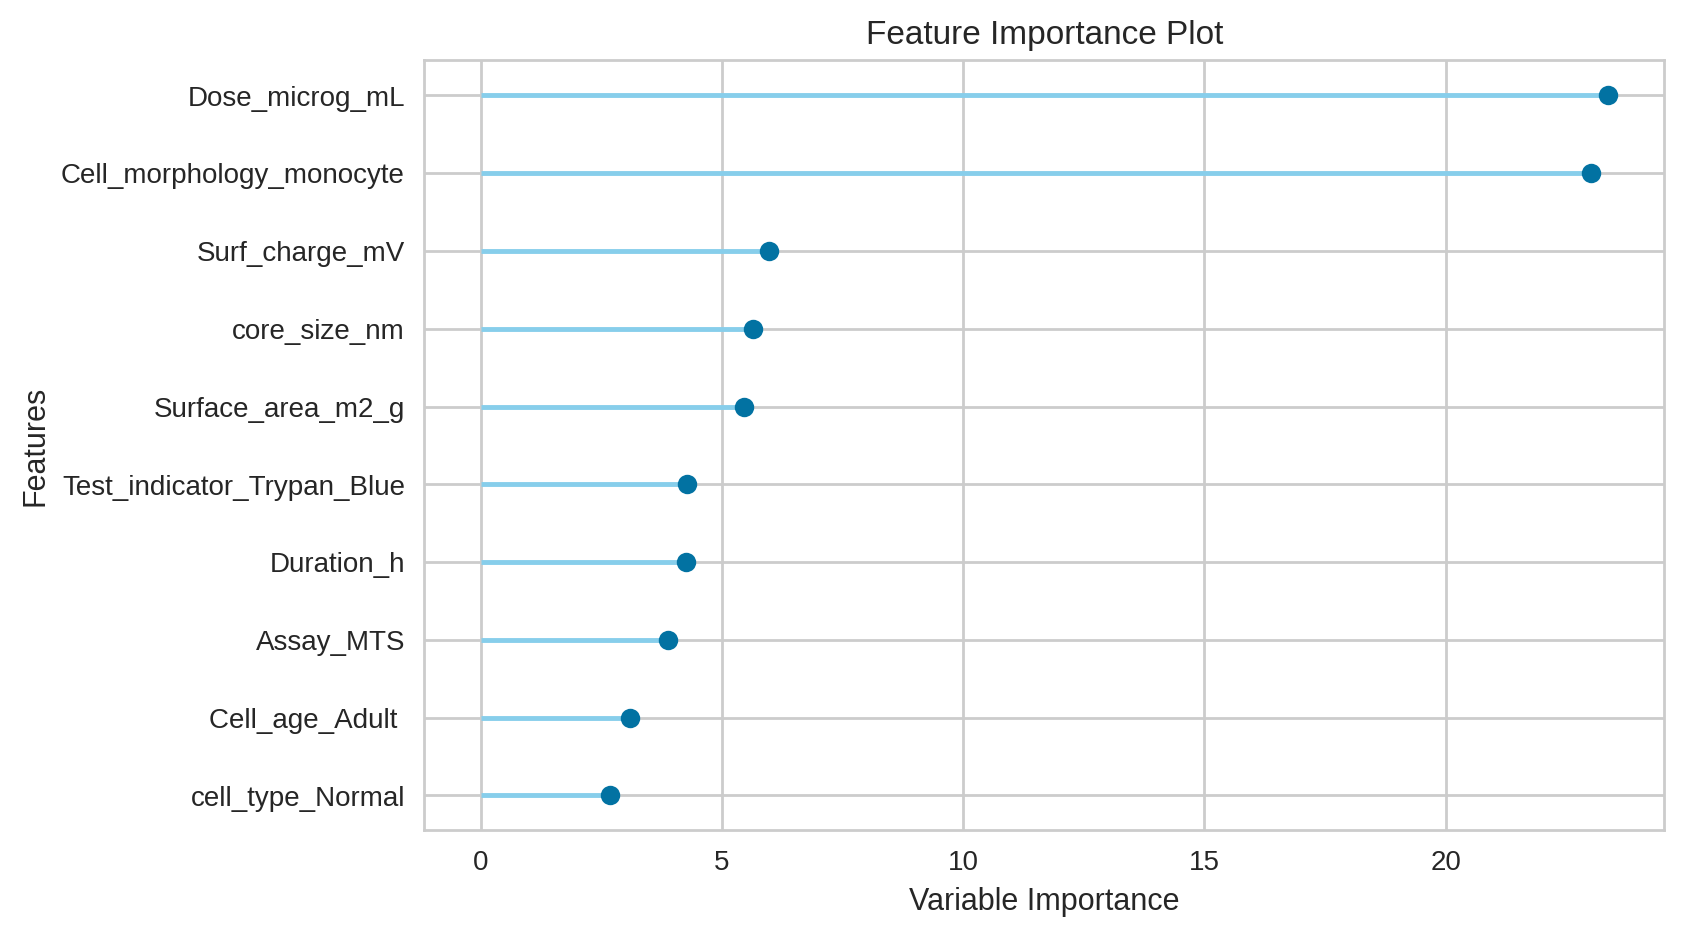

In [63]:
plot_model(best_nanotube_mdl, plot = 'feature')

# Train a model for quantum dots nanomaterials

## Use best scenario 8-3-1

In [64]:
best_scenario = [8 , 3, 1]

In [66]:
sc_ignore_features = features_scenarios[best_scenario[0]-1]["ignore_features"]
sc_bin_numeric_features = features_scenarios[best_scenario[0]-1]["bin_numeric_features"]
sc_high_cardinality_features = features_scenarios[best_scenario[0]-1]["high_cardinality_features"]

print(sc_ignore_features)
print(sc_bin_numeric_features)
print(sc_high_cardinality_features)


sc_imputation_type = imputation_scenarios[best_scenario[1]-1]["imputation_type"]
sc_numeric_imputation = imputation_scenarios[best_scenario[1]-1]["numeric_imputation"]

print(sc_imputation_type)
print(sc_numeric_imputation)

sc_normalize = preprocess_scenarios[best_scenario[2]-1]["normalize"]
sc_remove_outliers = preprocess_scenarios[best_scenario[2]-1]["remove_outliers"]

print(sc_normalize)
print(sc_remove_outliers)

['nanomaterial_group', 'Coating', 'Cell_name']
None
None
iterative
mean
True
True


In [67]:
data_quantum_dots_df = data_df[data_df['nanomaterial_group'] == 'quantum_dots']

In [68]:
data_quantum_dots_df.shape

(3019, 20)

In [88]:
data_quantum_dots_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,Viability,nanomaterial_group
112,CdTe,None,3.0,NaN,NaN,NaN,NaN,1.402864,24.0,4T1,Mouse,Breast,Epithelial,NaN,cancer,female,MTT,TetrazoliumSalt,74.18,quantum_dots
113,CdTe,None,3.0,NaN,NaN,NaN,NaN,1.402864,4.0,4T1,Mouse,Breast,Epithelial,NaN,cancer,female,MTT,TetrazoliumSalt,81.42,quantum_dots
114,CdTe,Folic_acid_based,3.0,NaN,NaN,NaN,NaN,1.402864,4.0,4T1,Mouse,Breast,Epithelial,NaN,cancer,female,MTT,TetrazoliumSalt,92.70,quantum_dots
115,CdTe,Doxorubicin,3.0,NaN,NaN,NaN,NaN,1.753580,4.0,4T1,Mouse,Breast,Epithelial,NaN,cancer,female,MTT,TetrazoliumSalt,54.05,quantum_dots
116,CdTe,Folic_acid_based,3.0,NaN,NaN,NaN,NaN,1.753580,4.0,95D,Human,Lung,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,18.92,quantum_dots


In [89]:
stup_qd = setup(data = data_quantum_dots_df, target = 'Viability', 
                    
        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        transform_target = False, 
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        # don't change the following
        session_id = 123,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'nanosafety')

,Description,Value
0,session_id,123
1,Target,Viability
2,Original Data,"(3019, 20)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,12
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2007, 104)"


In [90]:
best_quantum_dots_mdl = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,17.8779,562.1142,23.6422,0.3646,0.6432,0.7998,0.0300
catboost,CatBoost Regressor,17.9833,562.9932,23.6800,0.3643,0.6414,0.7901,2.5450
rf,Random Forest Regressor,17.4587,567.8587,23.7602,0.3572,0.6294,0.7319,0.1900
xgboost,Extreme Gradient Boosting,17.5898,579.2929,24.0080,0.3453,0.6197,0.7171,0.1980
gbr,Gradient Boosting Regressor,20.4369,644.0274,25.3582,0.2742,0.7072,0.9748,0.0530
knn,K Neighbors Regressor,20.4093,709.3258,26.6016,0.1984,0.7191,0.9456,0.0150
et,Extra Trees Regressor,18.6576,715.0340,26.6885,0.1896,0.6983,0.7051,0.1930
ridge,Ridge Regression,22.4119,767.5975,27.6952,0.1340,0.7564,1.0921,0.0070
lr,Linear Regression,22.3770,771.7897,27.7694,0.1286,0.7569,1.0814,0.4260
br,Bayesian Ridge,22.8239,778.5729,27.8929,0.1228,0.7645,1.1311,0.0100


In [91]:
save_model(best_quantum_dots_mdl, 'models/group-model-quantum-dots-top1-lightgbm.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Viability',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type...
                  LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_

## Plot feature importance of the quantum dots group model

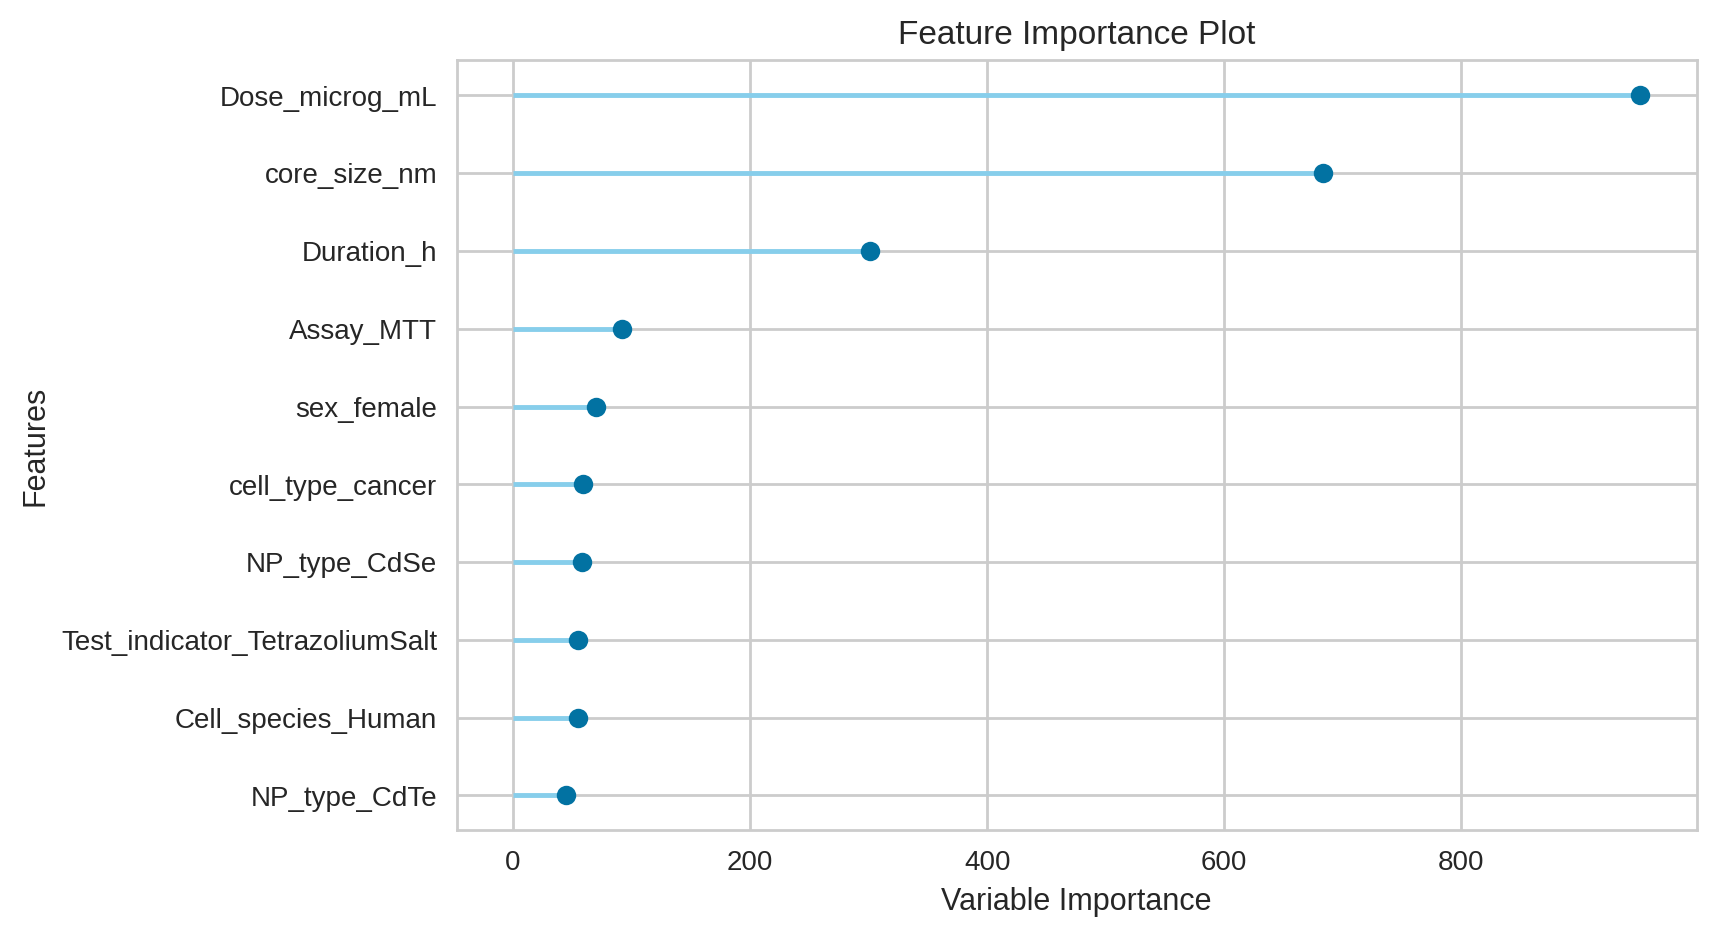

In [94]:
plot_model(best_quantum_dots_mdl, plot = 'feature')